In [1]:
!pip install -r "../requirements.txt"


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from one.api import ONE
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from one.api import ONE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import mlflow

In [3]:
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

In [4]:
mlflow.set_tracking_uri("http://0.0.0.0:5000/")
tracking_uri = mlflow.get_tracking_uri()
print(f"Current tracking uri: {tracking_uri}")
mlflow.set_experiment("nma")

Current tracking uri: http://0.0.0.0:5000/


<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1721942661809, experiment_id='2', last_update_time=1721942661809, lifecycle_stage='active', name='nma', tags={}>

## Load Data

In [5]:
one = ONE(base_url='https://openalyx.internationalbrainlab.org')

print(one.search_terms())

('dataset', 'date_range', 'laboratory', 'number', 'projects', 'subject', 'task_protocol', 'dataset_qc_lte')


In [6]:
one.describe_dataset('trials.table');

A table of trial events, one per trial. Events include: intervals, goCue_times, response_times, choice, stimOn_times, contrastLeft, contrastRight, feedback_times, feedbackType, rewardVolume, probabilityLeft, firstMovement_times


In [7]:
eids, details = one.search(dataset='trials.table', details=True)
# eids, details = one.search(dataset='alf/_ibl_trials.feedbackType.npy', details=True)
pprint(eids)
pprint(len(eids))
# pprint(details)
# pprint(len(details))

['ebce500b-c530-47de-8cb1-963c552703ea',
 'a7eba2cf-427f-4df9-879b-e53e962eae18',
 '3a3ea015-b5f4-4e8b-b189-9364d1fc7435',
 '5ae68c54-2897-4d3a-8120-426150704385',
 'd85c454e-8737-4cba-b6ad-b2339429d99b',
 '11163613-a6c9-4975-9586-84dc00481547',
 'de905562-31c6-4c31-9ece-3ee87b97eab4',
 '15b69921-d471-4ded-8814-2adad954bcd8',
 'e6594a5b-552c-421a-b376-1a1baa9dc4fd',
 '4e560423-5caf-4cda-8511-d1ab4cd2bf7d',
 'c46b8def-620d-4d70-9397-be5694255f73',
 '6899a67d-2e53-4215-a52a-c7021b5da5d4',
 '3f71aa98-08c6-4e79-b4c8-00eae4f03eff',
 'a1782f4f-86b0-480c-a7f2-3d8f1ab482ab',
 '97c1d08d-57b4-4595-8052-91eb84ebfd74',
 '35eeb752-8f4f-4040-9714-ba0f5b7ccdfe',
 '004d8fd5-41e7-4f1b-a45b-0d4ad76fe446',
 'ca4ecb4c-4b60-4723-9b9e-2c54a6290a53',
 '7dd27c2f-9544-448d-918d-be0f9837b0e0',
 'caa5dddc-9290-4e27-9f5e-575ba3598614',
 '642c97ea-fe89-4ec9-8629-5e492ea4019d',
 'e6bdb1f4-b0bf-4451-8f23-4384f2102f91',
 '2584ce3c-db10-4076-89cb-5d313138dd38',
 '1dbba733-24a4-4400-9436-53f1bd8428e8',
 'e6de6c35-1508-

In [19]:
# Initialize an empty list to hold DataFrames
dataframes = []

i = 25
eids_subset = eids[:i]
# Iterate over each eid and load trials data
for eid in eids_subset:
    try:
        # Load the trials dataset for the session
        trials = one.load_object(eid, 'trials', collection='alf')
        
        # Convert to DataFrame
        df = trials.to_df()
        
        # Add an identifier column for the session
        df['session_id'] = eid
        # add new features
        # Calculate previous reward and choice
        df['previous_reward'] = df['rewardVolume'].shift(1)
        df['previous_choice'] = df['choice'].shift(1)

        # Calculate cumulative reward
        df['cumulative_reward'] = df['rewardVolume'].cumsum()

        # Calculate reward slope (change in reward over trials)
        df['reward_slope'] = df['rewardVolume'].diff()

        # Define learning rate as the change in response times
        df['learning_rate'] = df['response_times'].diff()
        
        # Reaction time
        df['reaction_time'] = df['response_times'] - df['stimOn_times']
        
        # Append the DataFrame to the list
        dataframes.append(df)
        
        # Optional: print the shape and head of the DataFrame
        print(f"Session: {eid}, Shape: {df.shape}")
        print(df.head())
        
    except Exception as e:
        print(f"Error loading trials for session {eid}: {e}")

# Concatenate all DataFrames into a single DataFrame
all_trials_df = pd.concat(dataframes, ignore_index=True)

# Check the shape of the aggregated DataFrame
print(all_trials_df.shape)
all_trials_df.head()

Session: ebce500b-c530-47de-8cb1-963c552703ea, Shape: (569, 22)
   goCueTrigger_times  stimOff_times  goCue_times  response_times  choice  \
0           13.648230      15.156255    13.649192       14.099033    -1.0   
1           16.858861      18.258806    16.859900       17.199067     1.0   
2           19.872914      21.272799    19.873893       20.212920    -1.0   
3           23.692570      25.072820    23.693512       24.023372    -1.0   
4           27.242310      28.575402    27.243189       27.521317    -1.0   

   stimOn_times  contrastLeft  contrastRight  probabilityLeft  feedback_times  \
0     13.739751           NaN          1.000              0.5       14.099118   
1     16.858734          0.25            NaN              0.5       17.199169   
2     19.872693           NaN          0.250              0.5       20.213029   
3     23.692446           NaN          0.125              0.5       24.023482   
4     27.242123           NaN          0.250              0.5       

,goCueTrigger_times,stimOff_times,goCue_times,response_times,choice,stimOn_times,contrastLeft,contrastRight,probabilityLeft,feedback_times,...,firstMovement_times,intervals_0,intervals_1,session_id,previous_reward,previous_choice,cumulative_reward,reward_slope,learning_rate,reaction_time
0,13.648230,15.156255,13.649192,14.099033,-1.0,13.739751,NaN,1.000,0.5,14.099118,...,13.976156,12.933124,15.656348,ebce500b-c530-47de-8cb1-963c552703ea,NaN,NaN,1.5,NaN,NaN,0.359283
1,16.858861,18.258806,16.859900,17.199067,1.0,16.858734,0.25,NaN,0.5,17.199169,...,16.983156,16.302151,18.758896,ebce500b-c530-47de-8cb1-963c552703ea,1.5,-1.0,3.0,0.0,3.100033,0.340333
2,19.872914,21.272799,19.873893,20.212920,-1.0,19.872693,NaN,0.250,0.5,20.213029,...,19.987156,19.380104,21.772851,ebce500b-c530-47de-8cb1-963c552703ea,1.5,1.0,4.5,0.0,3.013853,0.340227
3,23.692570,25.072820,23.693512,24.023372,-1.0,23.692446,NaN,0.125,0.5,24.023482,...,23.805156,22.426161,25.572885,ebce500b-c530-47de-8cb1-963c552703ea,1.5,-1.0,6.0,0.0,3.810452,0.330926
4,27.242310,28.575402,27.243189,27.521317,-1.0,27.242123,NaN,0.250,0.5,27.521431,...,27.313156,26.182586,29.075456,ebce500b-c530-47de-8cb1-963c552703ea,1.5,-1.0,7.5,0.0,3.497945,0.279194


In [9]:
# Check contrast columns
contrast_columns = all_trials_df[['contrastLeft', 'contrastRight']]
contrast_columns

,contrastLeft,contrastRight
0,NaN,1.0000
1,0.250,NaN
2,NaN,0.2500
3,NaN,0.1250
4,NaN,0.2500
...,...,...
15376,NaN,0.0000
15377,NaN,0.2500
15378,0.125,NaN
15379,NaN,1.0000


In [10]:
# Check how many times both columns are NaN
both_nan_count = contrast_columns.isna().all(axis=1).sum()
both_nan_count

0

In [11]:
# select constrastLeft and if not contrastRight
all_trials_df['contrast'] = all_trials_df['contrastLeft'].fillna(all_trials_df['contrastRight'])
all_trials_df['contrast'].value_counts()

contrast
1.0000    3504
0.0625    3399
0.2500    3369
0.1250    3328
0.0000    1781
Name: count, dtype: int64

In [12]:
all_trials_df['feedbackType'].value_counts()

feedbackType
 1.0    12458
-1.0     2923
Name: count, dtype: int64

In [13]:
all_trials_df['rewardVolume'].value_counts()

rewardVolume
1.5    12458
0.0     2923
Name: count, dtype: int64

In [14]:
# Assuming df is your DataFrame
print(all_trials_df['rewardVolume'].isna().sum())  # This should print 0
print(all_trials_df['reward_slope'].isna().sum())  # This should print 25
print(all_trials_df[['rewardVolume', 'reward_slope']].head(30))  #

0
25
    rewardVolume  reward_slope
0            1.5           NaN
1            1.5           0.0
2            1.5           0.0
3            1.5           0.0
4            1.5           0.0
5            1.5           0.0
6            0.0          -1.5
7            1.5           1.5
8            0.0          -1.5
9            1.5           1.5
10           0.0          -1.5
11           1.5           1.5
12           0.0          -1.5
13           1.5           1.5
14           0.0          -1.5
15           0.0           0.0
16           1.5           1.5
17           1.5           0.0
18           1.5           0.0
19           0.0          -1.5
20           1.5           1.5
21           1.5           0.0
22           1.5           0.0
23           1.5           0.0
24           1.5           0.0
25           1.5           0.0
26           1.5           0.0
27           1.5           0.0
28           0.0          -1.5
29           1.5           1.5


In [15]:
all_trials_df.columns

Index(['goCueTrigger_times', 'stimOff_times', 'goCue_times', 'response_times',
       'choice', 'stimOn_times', 'contrastLeft', 'contrastRight',
       'probabilityLeft', 'feedback_times', 'feedbackType', 'rewardVolume',
       'firstMovement_times', 'intervals_0', 'intervals_1', 'session_id',
       'previous_reward', 'previous_choice', 'cumulative_reward',
       'reward_slope', 'learning_rate', 'contrast'],
      dtype='object')

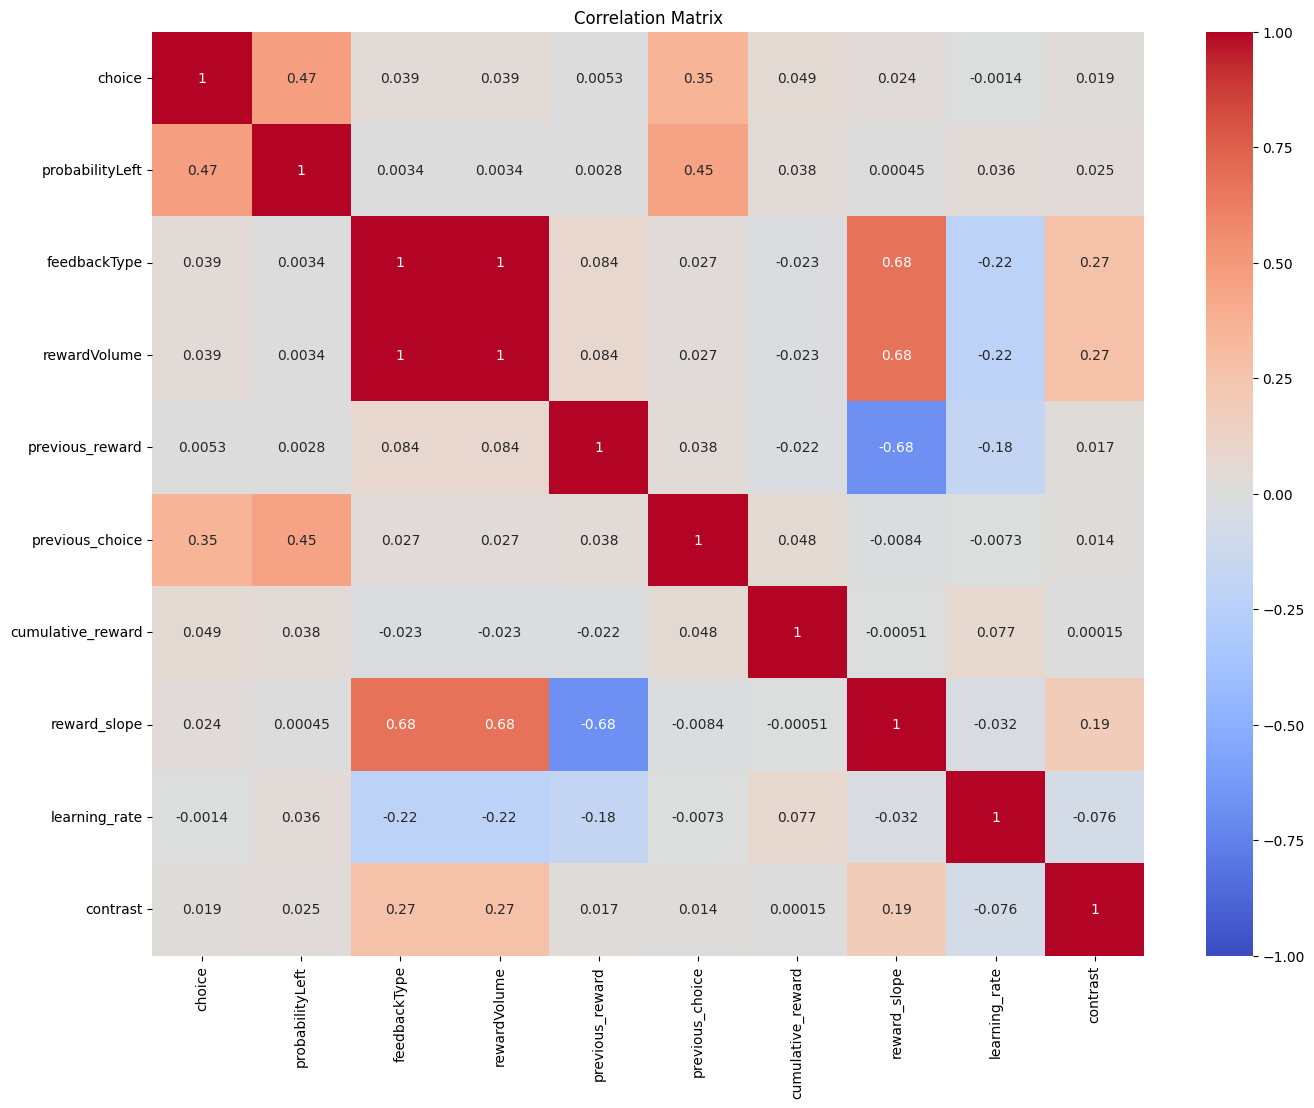

In [16]:
correlation_matrix = all_trials_df.drop(columns=["goCueTrigger_times","stimOff_times",
                                     "goCue_times", "response_times",
                                     "intervals_0","intervals_1","session_id",
                                     "contrastLeft", "contrastRight", "stimOn_times",
                                     "feedback_times", "firstMovement_times"]).corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [17]:
all_trials_df['previous_reward'] = all_trials_df['previous_reward'].fillna(0)
all_trials_df['reward_slope'] = all_trials_df['reward_slope'].fillna(0)

In [18]:
import mlflow.sklearn

def run_experiment(features):
    # Define the feature set and target variable
    X = all_trials_df[features]
    y = all_trials_df['feedbackType']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=35)
    
    # Initialize and train the model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Predict on the test set       
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    report = classification_report(y_test, y_pred, output_dict=True)
    matrix = confusion_matrix(y_test, y_pred)
    coef = model.coef_

    # Log parameters, metrics, and model
    with mlflow.start_run():
        mlflow.log_params({"features": features})
        mlflow.log_metrics({"precision": report['weighted avg']['precision'],
                            "recall": report['weighted avg']['recall'],
                            "f1-score": report['weighted avg']['f1-score']})
        mlflow.sklearn.log_model(model, "model")
        mlflow.log_dict(report, "classification_report.json")
        mlflow.log_dict({"confusion_matrix": matrix.tolist()}, "confusion_matrix.json")
        mlflow.log_dict({"coefficients": coef.tolist()}, "coefficients.json")
    
    print("Experiment completed with features:", features)

# Example feature sets
feature_sets = [
    ['contrast'],
    ['contrast', 'cumulative_reward'],
    ['contrast', 'cumulative_reward', 'previous_reward'],
    ['contrast', 'cumulative_reward', 'previous_reward', 'reward_slope']
]

# Run experiments for each feature set
for features in feature_sets:
    run_experiment(features)


/Users/guillemcomerma/Developer/nma/nma_cn_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/guillemcomerma/Developer/nma/nma_cn_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/guillemcomerma/Developer/nma/nma_cn_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

Experiment completed with features: ['contrast']


/Users/guillemcomerma/Developer/nma/nma_cn_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/guillemcomerma/Developer/nma/nma_cn_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/guillemcomerma/Developer/nma/nma_cn_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

Experiment completed with features: ['contrast', 'cumulative_reward']


/Users/guillemcomerma/Developer/nma/nma_cn_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/guillemcomerma/Developer/nma/nma_cn_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/guillemcomerma/Developer/nma/nma_cn_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

Experiment completed with features: ['contrast', 'cumulative_reward', 'previous_reward']
Experiment completed with features: ['contrast', 'cumulative_reward', 'previous_reward', 'reward_slope']


In [184]:
# Train model
# Split the data into training and test sets
X = all_trials_df[['contrast']] # 0 nan so no need to .fillna(0)
y = all_trials_df['feedbackType']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=35)

# Initialize and train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       849
         1.0       0.82      1.00      0.90      3766

    accuracy                           0.82      4615
   macro avg       0.41      0.50      0.45      4615
weighted avg       0.67      0.82      0.73      4615

[[   0  849]
 [   0 3766]]


/Users/guillemcomerma/Developer/nma/nma_cn_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/guillemcomerma/Developer/nma/nma_cn_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/guillemcomerma/Developer/nma/nma_cn_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

Accuracy: 0.82


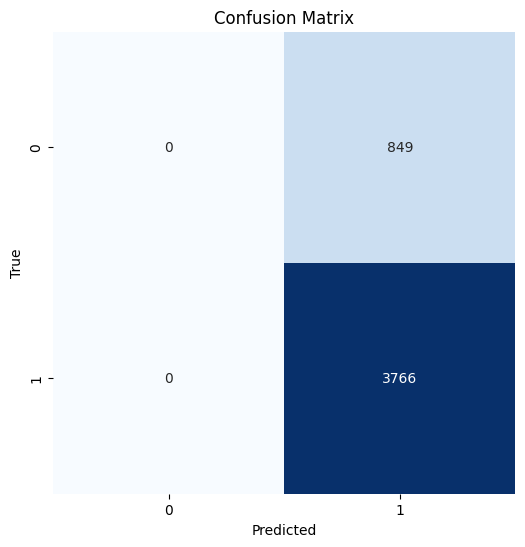

In [185]:
#Assume 'y_test' and 'y_pred' are already defined
accuracy = accuracy_score(y_test, y_pred)
conf_m = confusion_matrix(y_test, y_pred)

#Display the accuracy
print(f'Accuracy: {accuracy:.2f}')

#Display the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [186]:
all_trials_df['rewardVolume'].shape

(15381,)

In [187]:
all_trials_df['rewardVolume'].value_counts()

rewardVolume
1.5    12458
0.0     2923
Name: count, dtype: int64

In [188]:
all_trials_df.columns

Index(['goCueTrigger_times', 'stimOff_times', 'goCue_times', 'response_times',
       'choice', 'stimOn_times', 'contrastLeft', 'contrastRight',
       'probabilityLeft', 'feedback_times', 'feedbackType', 'rewardVolume',
       'firstMovement_times', 'intervals_0', 'intervals_1', 'session_id',
       'previous_reward', 'previous_choice', 'cumulative_reward',
       'reward_slope', 'learning_rate', 'contrast'],
      dtype='object')

In [189]:
if 'cumulative_reward' in all_trials_df.columns:
    print("Column 'cumulative_reward' exists.")
else:
    print("Column 'cumulative_reward' does not exist.")

Column 'cumulative_reward' exists.


In [190]:
all_trials_df['previous_reward'].isna().sum()

25

In [191]:
all_trials_df['previous_reward'] = all_trials_df['previous_reward'].fillna(0)

In [192]:
print(all_trials_df['previous_reward'].isna().sum())
print(all_trials_df['cumulative_reward'].isna().sum())
print(all_trials_df['reward_slope'].isna().sum())

0
0
25


In [193]:
all_trials_df['reward_slope'] = all_trials_df['reward_slope'].fillna(0)
print(all_trials_df['reward_slope'].isna().sum())

0


In [194]:
filtered_df = all_trials_df[all_trials_df['reward_slope'].isna()]
filtered_df

,goCueTrigger_times,stimOff_times,goCue_times,response_times,choice,stimOn_times,contrastLeft,contrastRight,probabilityLeft,feedback_times,...,firstMovement_times,intervals_0,intervals_1,session_id,previous_reward,previous_choice,cumulative_reward,reward_slope,learning_rate,contrast


In [195]:
print(all_trials_df['previous_reward'].shape)
print(all_trials_df['cumulative_reward'].shape)

(15381,)
(15381,)


In [197]:
# Inclue more features
# Split the data into training and test sets

# X = all_trials_df[['contrast', 'cumulative_reward']]  # Add more features as needed
# X = all_trials_df[['contrast', 'cumulative_reward', 'previous_reward']]  # Add more features as needed
X = all_trials_df[['contrast', 'cumulative_reward', 'previous_reward', 'reward_slope']]  # Add more features as needed
y = all_trials_df['feedbackType']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=35)

# Initialize and train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set       
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(model.coef_)

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99       849
         1.0       1.00      1.00      1.00      3766

    accuracy                           1.00      4615
   macro avg       0.99      1.00      1.00      4615
weighted avg       1.00      1.00      1.00      4615

[[ 849    0]
 [   9 3757]]
[[ 2.37673677e+00 -2.92595394e-03  6.97131381e+00  8.34177894e+00]]


Accuracy: 1.00


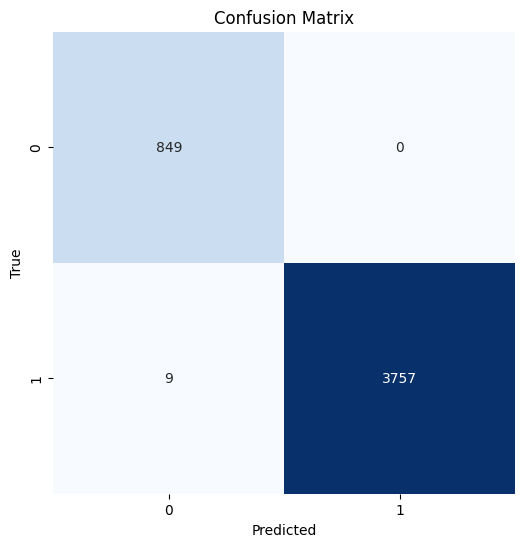

In [198]:
accuracy = accuracy_score(y_test, y_pred)
conf_m = confusion_matrix(y_test, y_pred)

#Display the accuracy
print(f'Accuracy: {accuracy:.2f}')

#Display the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [199]:
all_trials_df['learning_rate'].value_counts()

learning_rate
3.100033     1
3.064354     1
3.187444     1
4.985473     1
6.878511     1
            ..
6.273805     1
4.821912     1
4.620394     1
7.729904     1
15.420583    1
Name: count, Length: 15356, dtype: int64

In [200]:
all_trials_df['learning_rate'].isna().sum()

25

In [201]:
all_trials_df['learning_rate'] = all_trials_df['learning_rate'].fillna(0)

In [202]:
# Inclue more features
# Split the data into training and test sets
X = all_trials_df[['contrast', 'learning_rate']]  # Add more features as needed
y = all_trials_df['feedbackType']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=35)

# Initialize and train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set       
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(model.coef_)

              precision    recall  f1-score   support

        -1.0       0.53      0.06      0.11       849
         1.0       0.82      0.99      0.90      3766

    accuracy                           0.82      4615
   macro avg       0.68      0.52      0.50      4615
weighted avg       0.77      0.82      0.75      4615

[[  52  797]
 [  46 3720]]
[[ 3.86998721 -0.0712566 ]]


Accuracy: 0.82


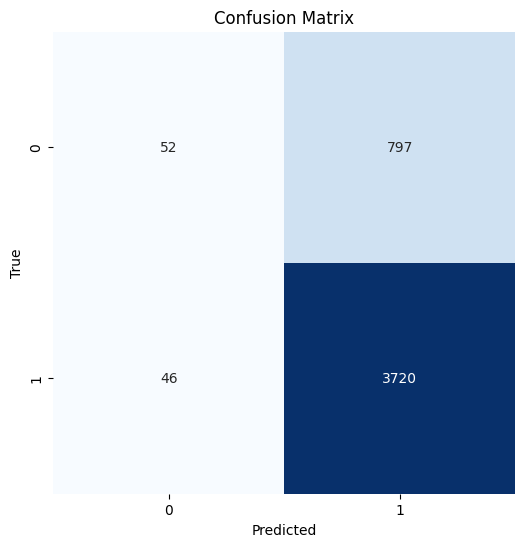

In [203]:
#Assume 'y_test' and 'y_pred' are already defined
accuracy = accuracy_score(y_test, y_pred)
conf_m = confusion_matrix(y_test, y_pred)

#Display the accuracy
print(f'Accuracy: {accuracy:.2f}')

#Display the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

SLIDES
intro - theory - hypothesis/model - results - conclusion